In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms


import glob

from PIL import Image
from torch.optim import lr_scheduler

torch.cuda.empty_cache()

In [42]:
train_imgs_path = glob.glob('../datasets/hk/training/*.png')
train_imgs_path.sort()

train_imgs = [img for img in train_imgs_path if 'matte' not in img]
train_mattes = [img for img in train_imgs_path if 'matte' in img]

order = np.random.permutation(len(train_imgs))
train_imgs = np.array(train_imgs)[order]
train_mattes = np.array(train_mattes)[order]

test_imgs_path = glob.glob('../datasets/hk/testing/*.png')
test_imgs_path.sort()

test_imgs = [img for img in test_imgs_path if 'matte' not in img]
test_mattes = [img for img in test_imgs_path if 'matte' in img]

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [43]:
class MyDataset(data.Dataset):
    def __init__(self, imgs, mattes):
        self.imgs = imgs
        self.mattes = mattes
        
    def __getitem__(self, index):
        img = self.imgs[index]
        matte = self.mattes[index]
        
        img = transform(Image.open(img)) 
        matte = transform(Image.open(matte))
        matte = torch.squeeze(matte).type(torch.long) # 去除维度为1 channels
        matte[matte > 0] = 1 # 分为两类
        
        return img, matte
    
    def __len__(self):
        return len(self.imgs)  

In [44]:
train_ds = MyDataset(train_imgs, train_mattes)
test_ds = MyDataset(test_imgs, test_mattes)

batch_size = 16
train_dl = data.DataLoader(train_ds, batch_size, shuffle=True)
test_dl = data.DataLoader(test_ds, batch_size)


#### Unet模型

In [45]:
class Downsample(nn.Module): # 下采样
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential( # 卷积
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2) # 池化
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x
    
class Upsample(nn.Module): # 上采样
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(2*channels, channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(channels, channels,  
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.upconv_relu = nn.Sequential( # 反卷积
                               nn.ConvTranspose2d(channels, 
                                                  channels//2, 
                                                  kernel_size=3,
                                                  stride=2, # 放大
                                                  padding=1, # 起始位置
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [46]:
class UnetModel(nn.Module):
    def __init__(self):
        super(UnetModel, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(1024, 
                                                  512, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024
        x5 = self.up1(x5)                         # 64*64*256)
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512  
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        
        x5 = self.last(x5)                        # 256*256*3
        return x5

#### LinkNet模型

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 k_size=3, 
                 stride=1, 
                 pad=1):
        super(ConvBlock, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=k_size,
                                      stride=stride,
                                      padding=pad),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
            )
    def forward(self, x):
        x = self.conv_relu(x)
        return x
    
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 k_size=3, 
                 stride=2, 
                 pad=1,
                 padding=1):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 
                                            kernel_size=k_size,
                                            stride=stride,
                                            padding=padding,
                                            output_padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
            
    def forward(self, x, is_act=True):
        x = self.deconv(x)
        if is_act:
            x = torch.relu(self.bn(x))
        return x
    
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncodeBlock, self).__init__()
        self.conv1_1 = ConvBlock(in_channels, out_channels, stride=2)
        self.conv1_2 = ConvBlock(out_channels, out_channels)
        self.conv2_1 = ConvBlock(out_channels, out_channels)
        self.conv2_2 = ConvBlock(out_channels, out_channels)
        self.shortcut = ConvBlock(in_channels, out_channels, stride=2)

    def forward(self, x):
        out1 = self.conv1_1(x)
        out1 = self.conv2_1(out1)
        residue = self.shortcut(x)
        out2 = self.conv2_1(out1 + residue)
        out2 = self.conv2_2(out2)
        return out2 + out1
    
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodeBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, in_channels//4, 
                               k_size=1, pad=0)
        self.deconv = DeconvBlock(in_channels//4, in_channels//4)
        self.conv2 = ConvBlock(in_channels//4, out_channels, 
                               k_size=1, pad=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        return x

In [ ]:
class LinknetModel(nn.Module):
    def __init__(self):
        super(LinknetModel, self).__init__()
        self.init_conv = ConvBlock(3, 64, 
                                   k_size=7, 
                                   stride=2,
                                   pad=3)
        self.init_maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.encode1 = EncodeBlock(64, 64)
        self.encode2 = EncodeBlock(64, 128)
        self.encode3 = EncodeBlock(128, 256)
        self.encode4 = EncodeBlock(256, 512)
        
        self.decode4 = DecodeBlock(512, 256)
        self.decode3 = DecodeBlock(256, 128)
        self.decode2 = DecodeBlock(128, 64)
        self.decode1 = DecodeBlock(64, 64)
        
        self.deconv_last1 = DeconvBlock(64, 32)
        self.conv_last = ConvBlock(32, 32)
        self.deconv_last2 = DeconvBlock(32, 2, 
                                        k_size=2,
                                        pad=0,
                                        padding=0)
    
    def forward(self, x):
        x = self.init_conv(x)              #  (6, 128, 128, 64)
        x = self.init_maxpool(x)           #  (6, 64, 64, 64)
        
        e1 = self.encode1(x)               #  (6, 32, 32, 64)
        e2 = self.encode2(e1)              #  (6, 16, 16, 128)
        e3 = self.encode3(e2)              #  (6, 8, 8, 256)
        e4 = self.encode4(e3)              #  (6, 4, 4, 512)        
        
        d4 = self.decode4(e4) + e3
        d3 = self.decode3(d4) + e2
        d2 = self.decode2(d3) + e1
        d1 = self.decode1(d2)
        
        f1 = self.deconv_last1(d1)
        f2 = self.conv_last(f1)
        f3 = self.deconv_last2(f2, is_act=False)
        
        return f3

In [47]:
model = UnetModel().cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [48]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [49]:
epochs = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.041 accuracy: 0.628 test_loss：  0.039 test_accuracy: 0.716
epoch:  1 loss：  0.031 accuracy: 0.773 test_loss：  0.028 test_accuracy: 0.805
epoch:  2 loss：  0.024 accuracy: 0.832 test_loss：  0.022 test_accuracy: 0.85
epoch:  3 loss：  0.022 accuracy: 0.848 test_loss：  0.022 test_accuracy: 0.845
epoch:  4 loss：  0.022 accuracy: 0.848 test_loss：  0.021 test_accuracy: 0.856
epoch:  5 loss：  0.022 accuracy: 0.851 test_loss：  0.021 test_accuracy: 0.856
epoch:  6 loss：  0.022 accuracy: 0.849 test_loss：  0.021 test_accuracy: 0.857
epoch:  7 loss：  0.02 accuracy: 0.863 test_loss：  0.02 test_accuracy: 0.865
epoch:  8 loss：  0.02 accuracy: 0.867 test_loss：  0.02 test_accuracy: 0.868
epoch:  9 loss：  0.019 accuracy: 0.87 test_loss：  0.019 test_accuracy: 0.869


In [50]:
test_imgs_batch,test_mattes_batch = next(iter(test_dl))

pred_imgs = model(test_imgs_batch.cuda())

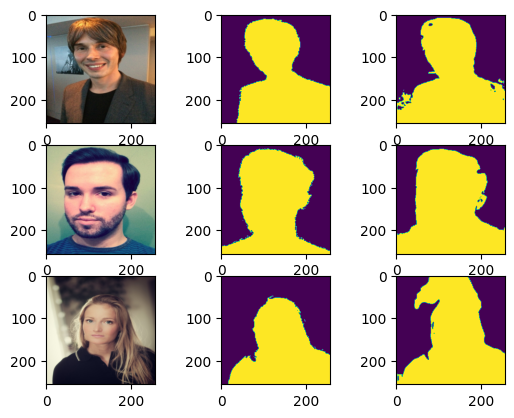

In [79]:
num = 3
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(test_imgs_batch[i].permute(1,2,0).cpu())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(test_mattes_batch[i].cpu()) # 两个像素图像之前预处理过
    plt.subplot(num, 3, i*num+3)
    # 对channels取最大值的位置对应黑白像素，取实际值data
    plt.imshow(torch.argmax(pred_imgs[i].permute(1,2,0), axis=-1).detach().cpu())